<a href="https://colab.research.google.com/github/jblackM1/AAI_590-Capstone-Project/blob/main/AAI_590_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/rules

# Libraries and Setup

In [73]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached httpstan-4.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (44.4 MB)
  Using cached pysimdjson-5.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
  Using cached crashtest-0.3.1-py3-none-any.whl (7.0 kB)
  Using cached pastel-0.2.1-py2.py3-none-any.whl (6.0 kB)
  Using cached pylev-1.4.0-py2.py3-none-any.whl (6.1 kB)
  Using cached marshmallow-3.20.1-py3-none-any.w

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import dask.dataframe as dd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [ ]:
#@title Kaggle Json

from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
#@title Install Kaggle

! pip install kaggle

In [ ]:
#@title Configure Kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Data Loading (H&M Data Setup)

In [ ]:
#@title Download Data - H&M

!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

In [ ]:
#@title Unzip files

! unzip -n /content/h-and-m-personalized-fashion-recommendations.zip -d /content/drive/MyDrive/h-and-m-personalized-fashion-recommendations


## Data Loading (Product Reviews)

In [ ]:
#@title Download Data - Product Reviews

!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews

In [ ]:
#@title Unzip files

! unzip -n /content/womens-ecommerce-clothing-reviews.zip -d /content/drive/MyDrive/womens-ecommerce-clothing-reviews

# Data Setup

In [76]:
#@title Load H&M Transactions data
file_path = '/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [77]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [78]:
len(df)

31788324

In [79]:
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [80]:
# Convert the 't_dat' column to datetime format
df['t_dat'] = pd.to_datetime(df['t_dat'])
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [81]:
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                   int64
price                      float64
sales_channel_id             int64
dtype: object

In [82]:
#@title Load H&M Articles data
file_path = '/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv'

# Read the CSV file into a DataFrame
df_article_info = pd.read_csv(file_path)

In [83]:
df_article_info.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [84]:
#@title Load Product Review data
# Replace the file path with your actual file path
file_path = '/content/drive/MyDrive/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv'

# Read the CSV file into a DataFrame
df_product_reviews = pd.read_csv(file_path)

In [85]:
df_product_reviews.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [86]:
df_product_reviews.dtypes

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [87]:
#@title Top Products Review
# Replace the file path with your actual file path
file_path = '/content/top_products_reviews.csv'

# Read the CSV file into a DataFrame
top_products_reviews = pd.read_csv(file_path)
top_products = df_article_info[df_article_info['product_type_name'] == 'Top']
top_products = top_products.sample(frac=0.75, random_state=42)

# Feature Engineering

In [88]:
num_transactions = len(df)
print(num_transactions)

start_date = df['t_dat'].min()
end_date = df['t_dat'].max()

print(f"Time frame of transactions: {start_date} to {end_date}")

31788324
Time frame of transactions: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [89]:
# Merge data frames
ddf = dd.merge(df, df_article_info, on='article_id', how='inner')

# If 'df' and 'df_article_info' are pandas DataFrames, you can convert them to Dask DataFrames:
ddf = dd.from_pandas(df, npartitions=10)  # You can adjust the number of partitions

# Perform the merge operation
merged_ddf = dd.merge(ddf, df_article_info, on='article_id', how='inner')

# Compute the result into a Pandas DataFrame
merged_df = merged_ddf.compute()

In [90]:
merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

# EDA

In [91]:
merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,663713001,0.049475,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
2,2018-09-20,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
3,2018-09-20,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,663713001,0.050831,1,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
4,2018-09-20,8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."


In [92]:
print(merged_df.describe())

         article_id         price  sales_channel_id  product_code  \
count  3.178832e+07  3.178832e+07      3.178832e+07  3.178832e+07   
mean   6.962272e+08  2.782927e-02      1.704028e+00  6.962272e+05   
std    1.334480e+08  1.918113e-02      4.564786e-01  1.334480e+05   
min    1.087750e+08  1.694915e-05      1.000000e+00  1.087750e+05   
25%    6.328030e+08  1.581356e-02      1.000000e+00  6.328030e+05   
50%    7.145820e+08  2.540678e-02      2.000000e+00  7.145820e+05   
75%    7.865240e+08  3.388136e-02      2.000000e+00  7.865240e+05   
max    9.562170e+08  5.915254e-01      2.000000e+00  9.562170e+05   

       product_type_no  graphical_appearance_no  colour_group_code  \
count     3.178832e+07             3.178832e+07       3.178832e+07   
mean      2.462434e+02             1.009727e+06       2.631858e+01   
std       6.779323e+01             1.701311e+04       2.620701e+01   
min      -1.000000e+00            -1.000000e+00      -1.000000e+00   
25%       2.530000e+02      

In [93]:
print(merged_df.isnull().sum())

t_dat                                0
customer_id                          0
article_id                           0
price                                0
sales_channel_id                     0
product_code                         0
prod_name                            0
product_type_no                      0
product_type_name                    0
product_group_name                   0
graphical_appearance_no              0
graphical_appearance_name            0
colour_group_code                    0
colour_group_name                    0
perceived_colour_value_id            0
perceived_colour_value_name          0
perceived_colour_master_id           0
perceived_colour_master_name         0
department_no                        0
department_name                      0
index_code                           0
index_name                           0
index_group_no                       0
index_group_name                     0
section_no                           0
section_name             

In [94]:
num_garment_groups = df_article_info['garment_group_name'].nunique()

print(f"Number of Garment Groups: {num_garment_groups}")

Number of Garment Groups: 21


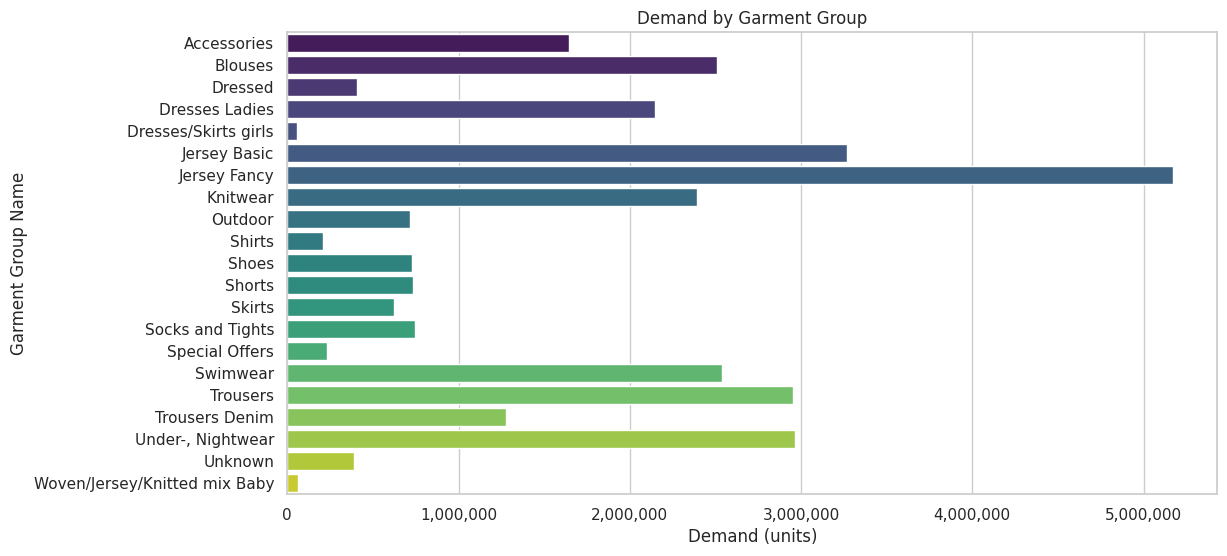

In [95]:
#@title Demand by Garment Group

# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['garment_group_name']).size().reset_index(name='demand')

top_garment_group = demand_by_category.groupby('garment_group_name')['demand'].sum().nlargest(21).index

# Filter the DataFrame for the top 10 departments
top_garment_group_data = demand_by_category[demand_by_category['garment_group_name'].isin(top_garment_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='garment_group_name', data=top_garment_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))


plt.title('Demand by Garment Group')
plt.xlabel('Demand (units)')
plt.ylabel('Garment Group Name')
plt.show()

In [96]:
num_departments = df_article_info['department_name'].nunique()

print(f"Number of Departments: {num_departments}")

Number of Departments: 250


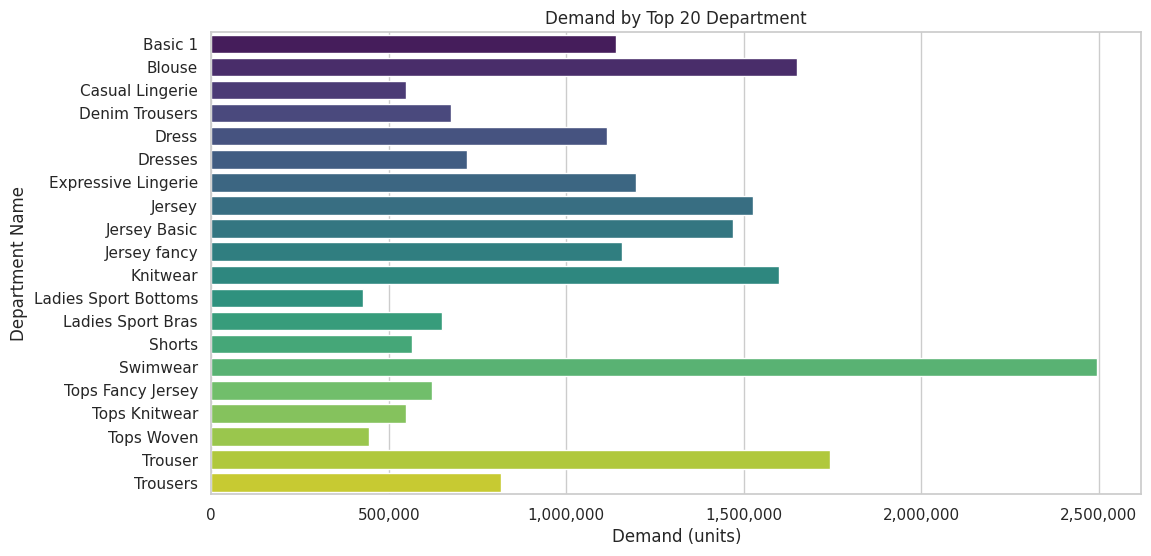

In [97]:
#@title Demand by Department

# Get the top 10 departments by demand
demand_by_category = merged_df.groupby(['department_name']).size().reset_index(name='demand')

top_garment_group = demand_by_category.groupby('department_name')['demand'].sum().nlargest(20).index

# Filter the DataFrame for the top 10 departments
top_garment_group_data = demand_by_category[demand_by_category['department_name'].isin(top_garment_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 departments
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='department_name', data=top_garment_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Top 20 Department')
plt.xlabel('Demand (units)')
plt.ylabel('Department Name')
plt.show()

In [98]:
num_product_types = df_article_info['product_type_name'].nunique()

print(f"Number of Product Types: {num_product_types}")

Number of Product Types: 131


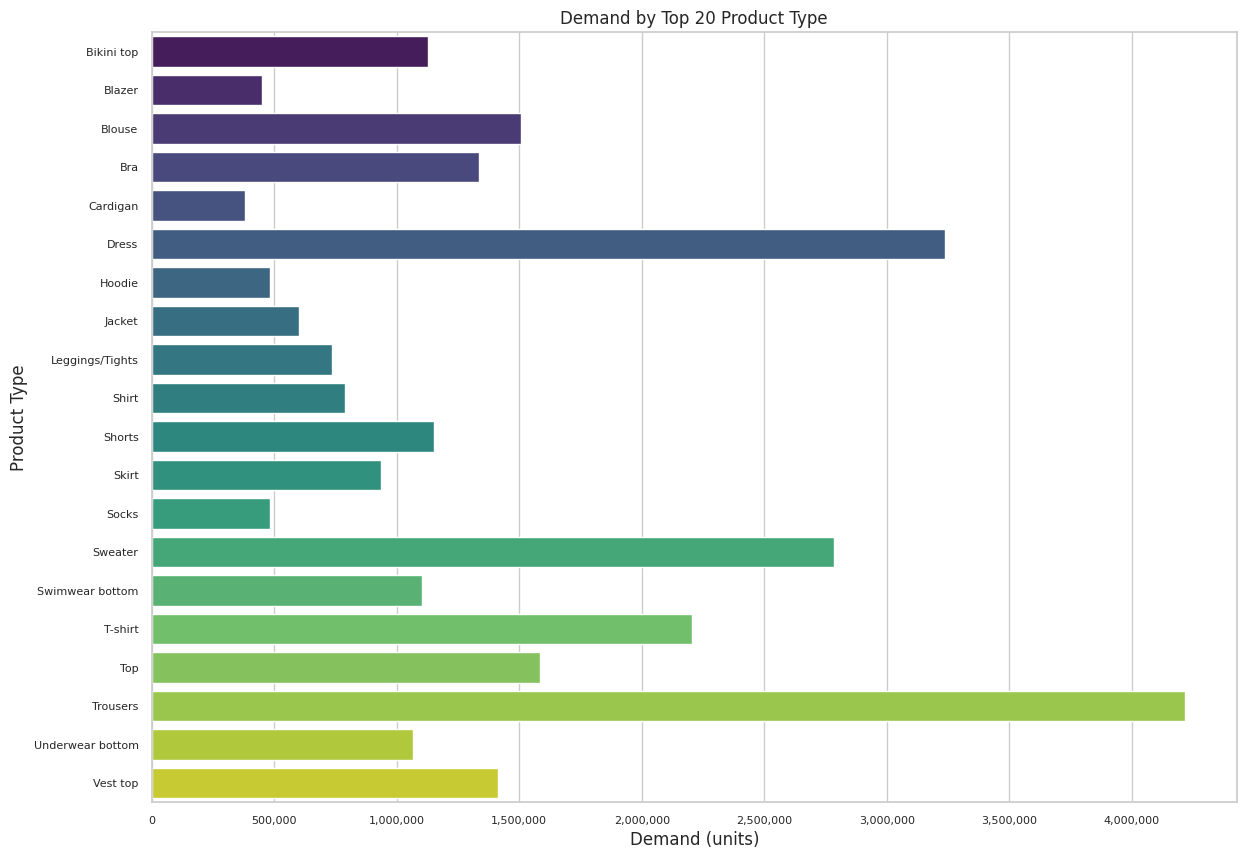

In [99]:
#@title Demand by Product Type

# Get the top 10 product type by demand
demand_by_category = merged_df.groupby(['product_type_name']).size().reset_index(name='demand')

top_product_type = demand_by_category.groupby('product_type_name')['demand'].sum().nlargest(20).index

# Filter the DataFrame for the top 10 product type
top_product_type_data = demand_by_category[demand_by_category['product_type_name'].isin(top_product_type)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 product type
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='demand', y='product_type_name', data=top_product_type_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.title('Demand by Top 20 Product Type')
plt.xlabel('Demand (units)')
plt.ylabel('Product Type')
plt.show()

In [100]:
num_product_groups = df_article_info['product_group_name'].nunique()

print(f"Number of Product Groups: {num_product_groups}")

Number of Product Groups: 19


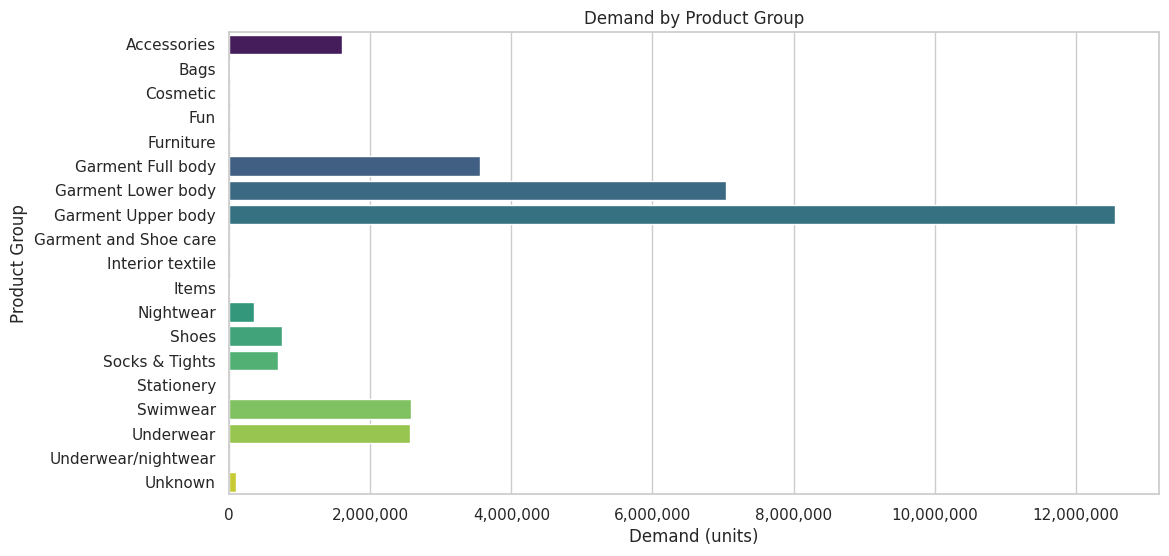

In [101]:
#@title Demand by Product Group

# Get the top 10 product group by demand
demand_by_category = merged_df.groupby(['product_group_name']).size().reset_index(name='demand')

top_product_group = demand_by_category.groupby('product_group_name')['demand'].sum().nlargest(19).index

# Filter the DataFrame for the top 10 product group
top_product_group_data = demand_by_category[demand_by_category['product_group_name'].isin(top_product_group)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 product group
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='product_group_name', data=top_product_group_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Product Group')
plt.xlabel('Demand (units)')
plt.ylabel('Product Group')
plt.show()

In [102]:
# Assuming 'df_article_info' is your DataFrame
num_indexes = df_article_info['index_name'].nunique()

print(f"Number of Indexes: {num_indexes}")

Number of Indexes: 10


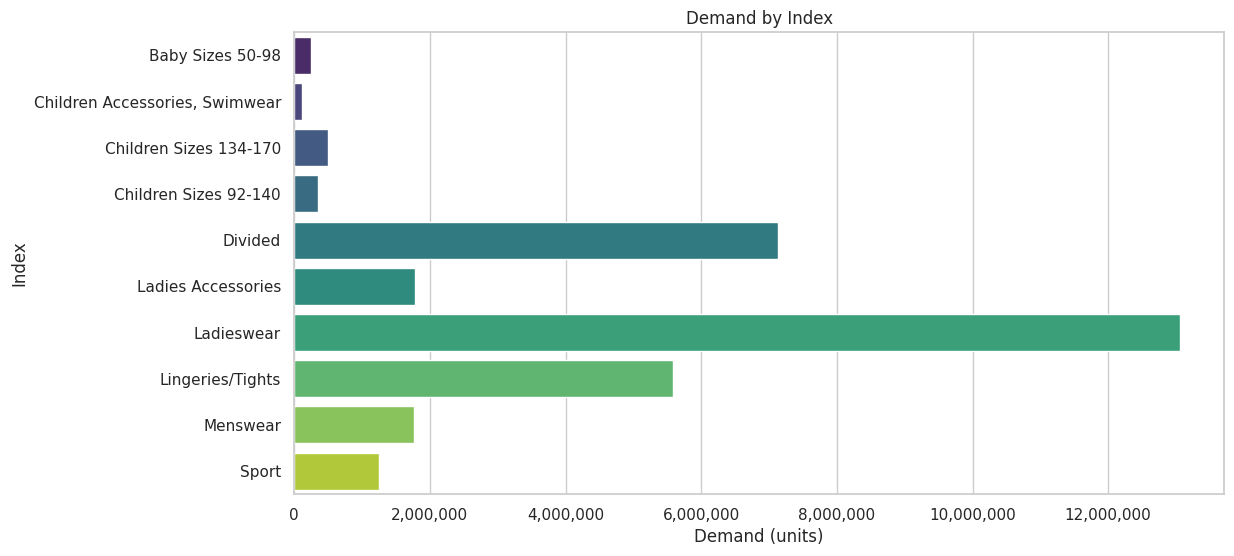

In [103]:
#@title Demand by Index

demand_by_category = merged_df.groupby(['index_name']).size().reset_index(name='demand')

top_index = demand_by_category.groupby('index_name')['demand'].sum().nlargest(10).index

# Filter the DataFrame for the top 10 index
top_index_data = demand_by_category[demand_by_category['index_name'].isin(top_index)]

# Set the plotting style
sns.set(style="whitegrid")

# Plot the demand by department for the top 10 index
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='demand', y='index_name', data=top_index_data, palette='viridis')

# Format y-axis labels as integers
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(int(x))))

plt.title('Demand by Index')
plt.xlabel('Demand (units)')
plt.ylabel('Index')
plt.show()

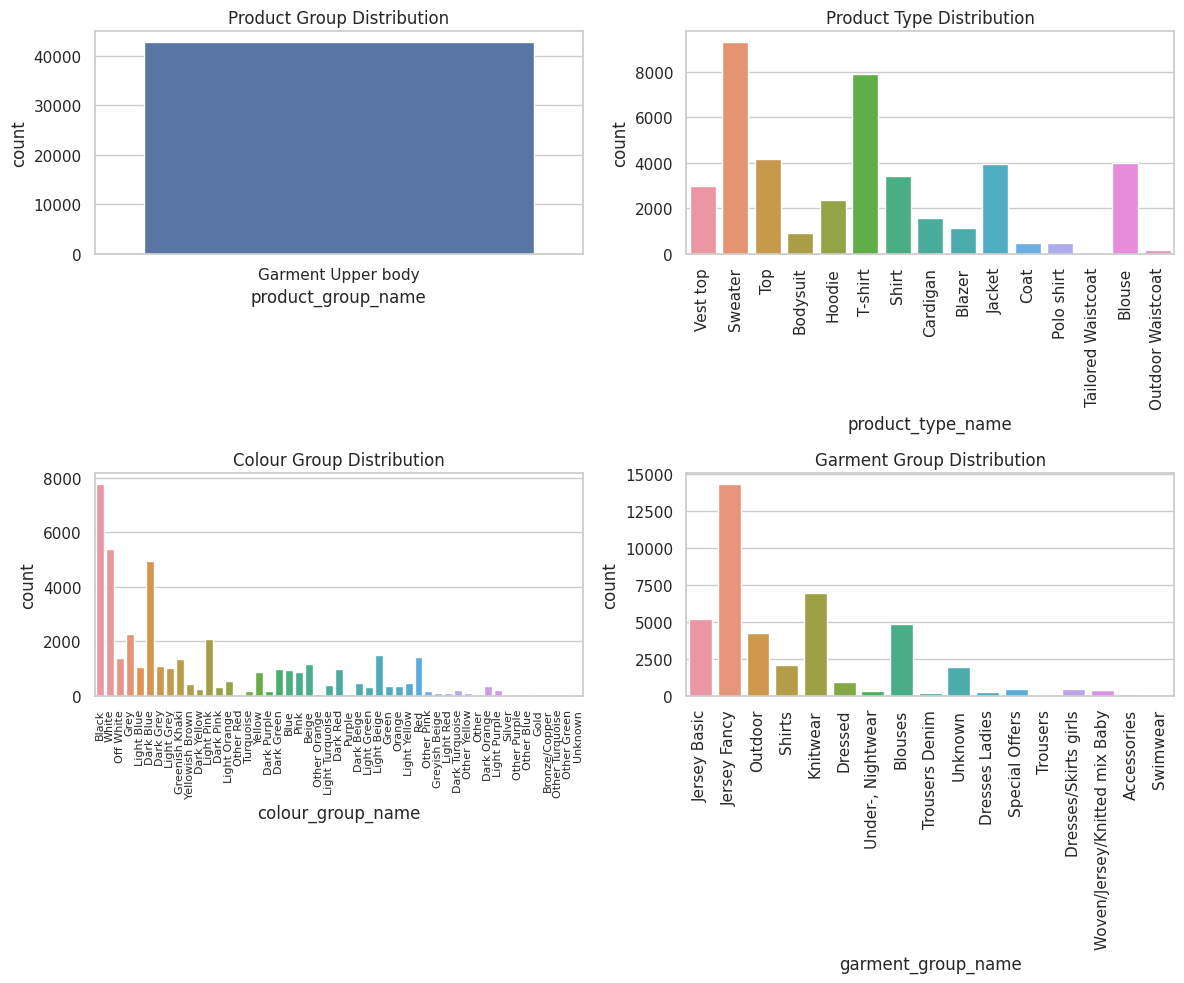

In [104]:
#@title Summary visualization
# Set the style of the visualization (optional)
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

df_filtered = df_article_info[df_article_info['product_group_name'] == 'Garment Upper body']

# Bar chart for product_type_name
sns.countplot(x='product_group_name', data=df_filtered, ax=axes[0, 0])
axes[0, 0].set_title('Product Group Distribution')
axes[0, 0].tick_params(axis='x', rotation=0)  # Rotate x-axis labels for better visibility

# Bar chart for department_name
sns.countplot(x='product_type_name', data=df_filtered, ax=axes[0, 1])
axes[0, 1].set_title('Product Type Distribution')
axes[0, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Bar chart for colour_group_name
sns.countplot(x='colour_group_name', data=df_filtered, ax=axes[1, 0])
axes[1, 0].set_title('Colour Group Distribution')
axes[1, 0].tick_params(axis='x', rotation=90, labelsize=8)  # Rotate x-axis labels for better visibility


# Bar chart for garment_group_name
sns.countplot(x='garment_group_name', data=df_filtered, ax=axes[1, 1])
axes[1, 1].set_title('Garment Group Distribution')
axes[1, 1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

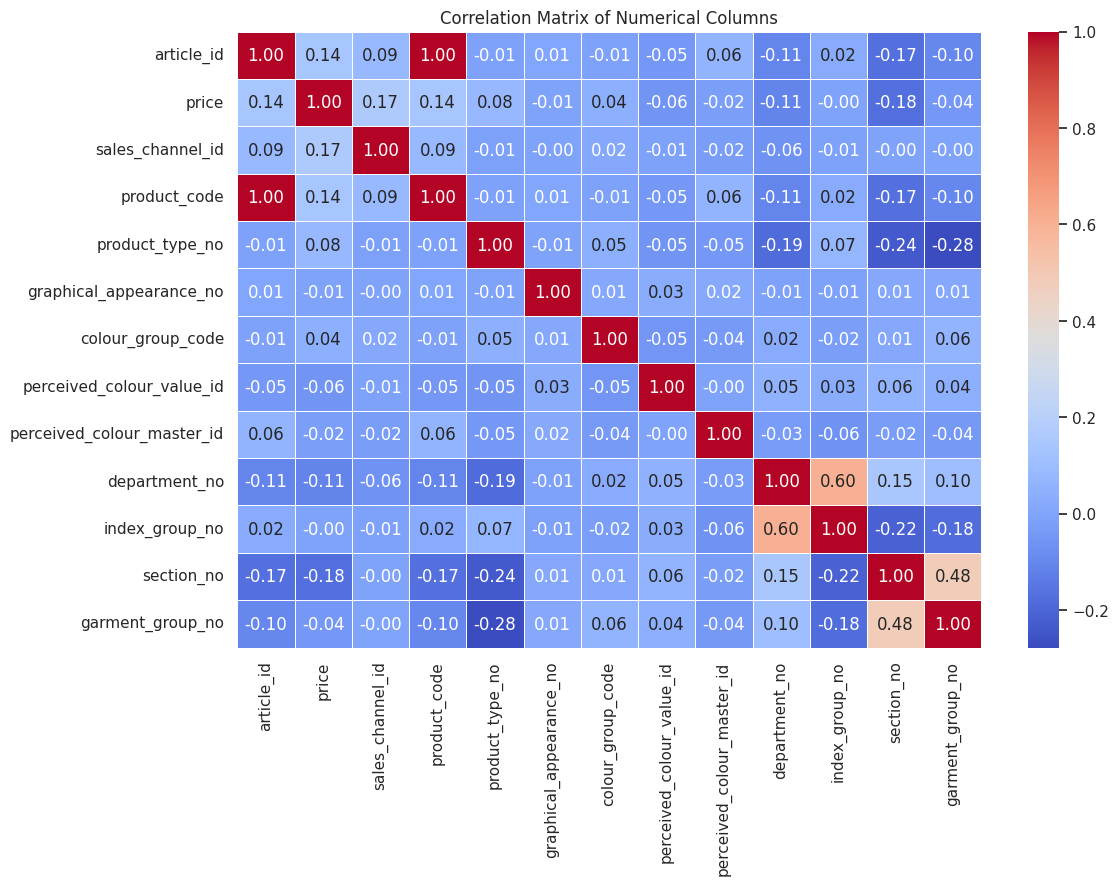

In [105]:
#@title Correlation Matrix

# Considering only numerical columns for simplicity
numerical_columns = merged_df.select_dtypes(include=['int64', 'float64']).columns

# Calculate the correlation matrix
correlation_matrix = merged_df[numerical_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [106]:
df_product_reviews.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [107]:
df_product_reviews.dtypes

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [108]:
len(df_product_reviews)

23486

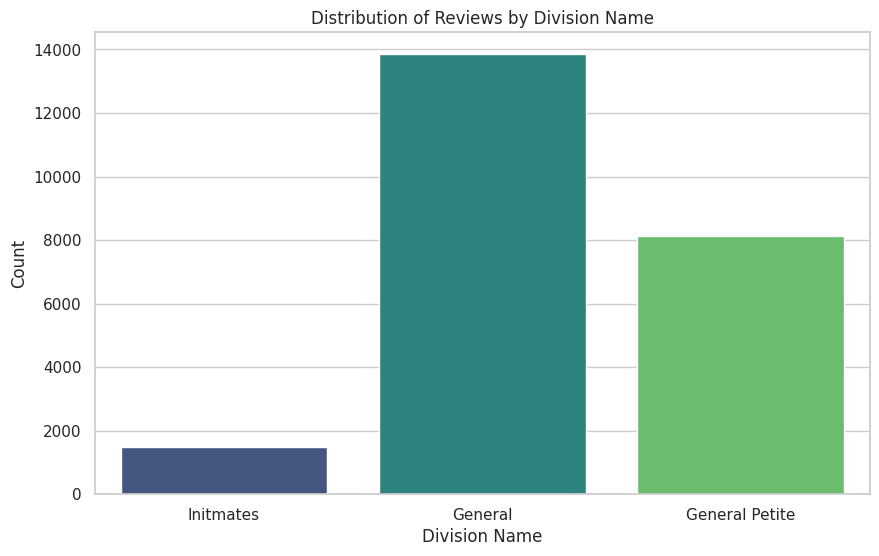

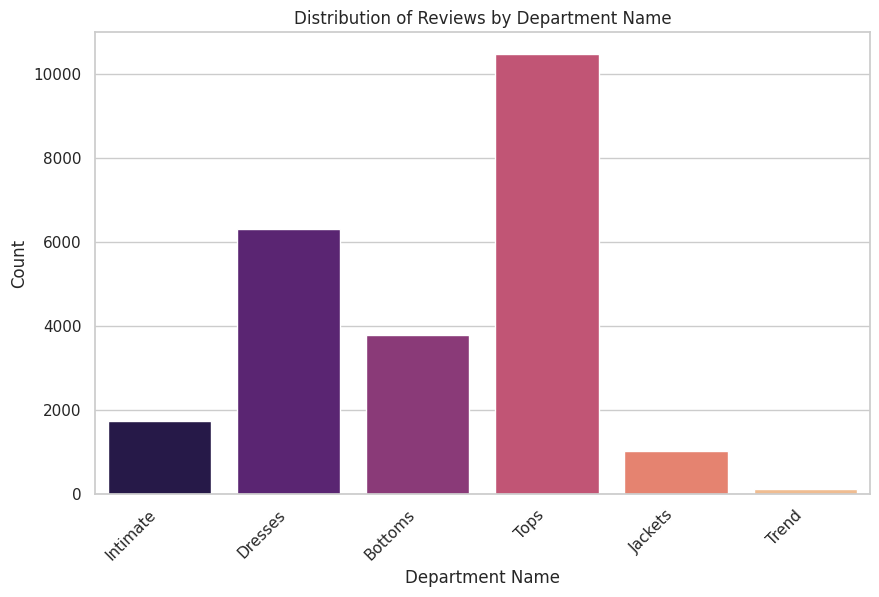

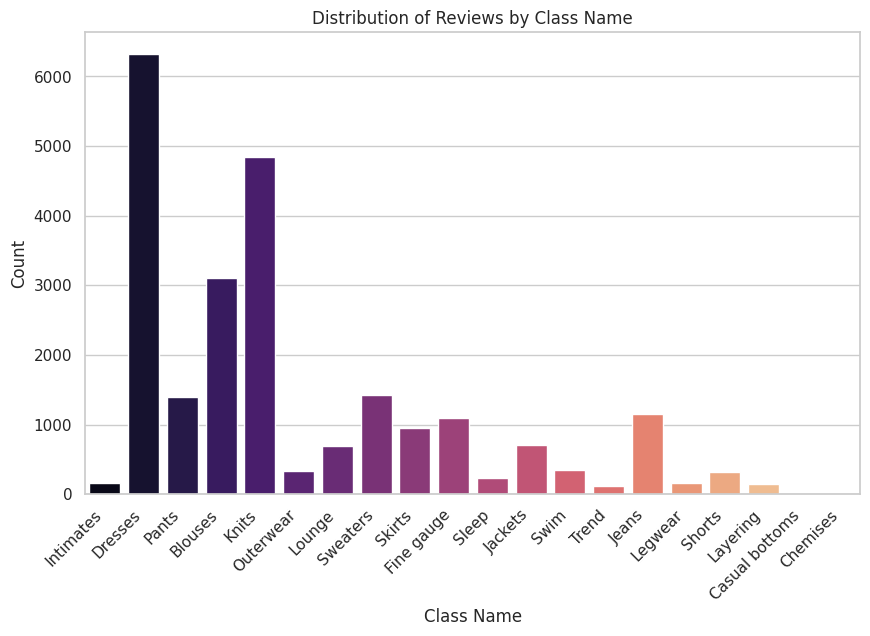

In [109]:
#@title Product Review Visualization

# Bar chart for Division Name
plt.figure(figsize=(10, 6))
sns.countplot(x='Division Name', data=df_product_reviews, palette='viridis')
plt.title('Distribution of Reviews by Division Name')
plt.xlabel('Division Name')
plt.ylabel('Count')
plt.show()

# Bar chart for Department Name
plt.figure(figsize=(10, 6))
sns.countplot(x='Department Name', data=df_product_reviews, palette='magma')
plt.title('Distribution of Reviews by Department Name')
plt.xlabel('Department Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Bar chart for Department Name
plt.figure(figsize=(10, 6))
sns.countplot(x='Class Name', data=df_product_reviews, palette='magma')
plt.title('Distribution of Reviews by Class Name')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# LSTM Model (Time Series)

In [110]:
# Assuming 'merged_df' is your DataFrame
filtered_merged_df = merged_df[merged_df['garment_group_name'].str.contains("Jersey Fancy", case=False, na=False)]

In [111]:
filtered_merged_df.dtypes

t_dat                           datetime64[ns]
customer_id                             object
article_id                               int64
price                                  float64
sales_channel_id                         int64
product_code                             int64
prod_name                               object
product_type_no                          int64
product_type_name                       object
product_group_name                      object
graphical_appearance_no                  int64
graphical_appearance_name               object
colour_group_code                        int64
colour_group_name                       object
perceived_colour_value_id                int64
perceived_colour_value_name             object
perceived_colour_master_id               int64
perceived_colour_master_name            object
department_no                            int64
department_name                         object
index_code                              object
index_name   

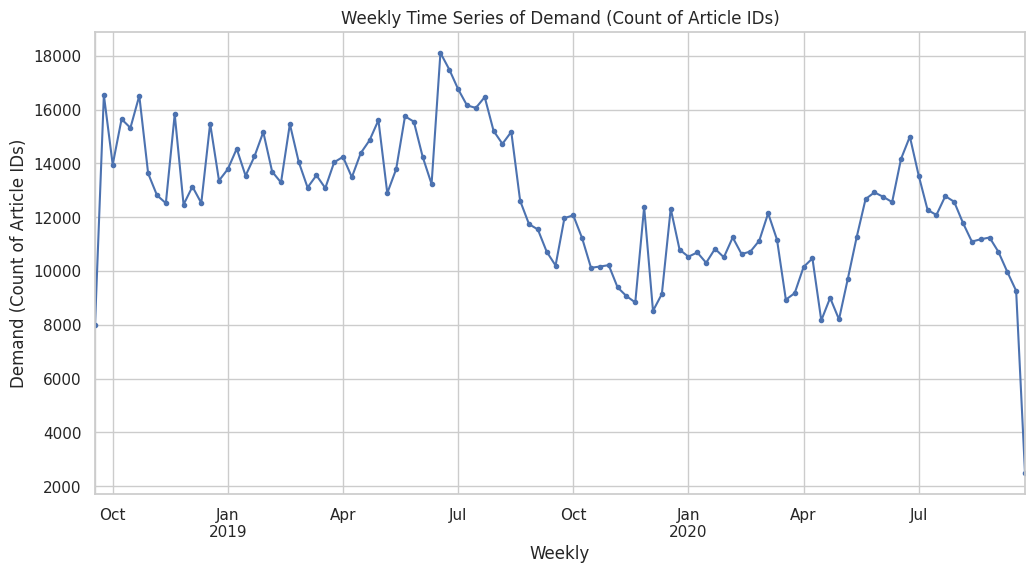

In [126]:
time_series_data = filtered_merged_df.groupby('t_dat')['article_id'].nunique()

# Resample the time series data to weekly frequency
time_series_data_weekly = time_series_data.resample('W').sum()

# Plot the time series
time_series_data_weekly.plot(style='.-', figsize=(12, 6), title='Weekly Time Series of Demand (Count of Article IDs)')
plt.xlabel('Weekly')
plt.ylabel('Demand (Count of Article IDs)')
plt.show()

In [127]:
time_series_data = filtered_merged_df.groupby('t_dat')['article_id'].nunique().reset_index()
time_series_data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Normalize the 'y' values
scaler = MinMaxScaler()
time_series_data['y_normalized'] = scaler.fit_transform(time_series_data[['y']])

# Create sequences of data with n_steps time steps
n_steps = 10
X, y = [], []
for i in range(len(time_series_data) - n_steps):
    X.append(time_series_data['y_normalized'].values[i:i+n_steps])
    y.append(time_series_data['y_normalized'].values[i+n_steps])

X, y = np.array(X), np.array(y)

# Reshape X to be 3D (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [128]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [129]:
# Define the LSTM model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.3)
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(n_steps, 1), return_sequences=True))
model.add(LSTM(units=100, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')



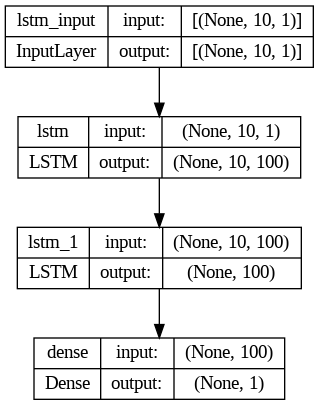

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [117]:
# Fit the LSTM model on the training set
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
19/19 [==============================] - 3s 14ms/step - loss: 0.1016
Epoch 2/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0208
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0138
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0129
Epoch 5/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0125
Epoch 6/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0120
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0119
Epoch 8/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0129
Epoch 9/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0118
Epoch 10/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0115
Epoch 11/100
19/19 [==============================] - 0s 14ms/step - loss: 0.0116
Epoch 12/100
19/19 [==============================] - 0s 13ms/step - loss: 0.0115
Epoch 13/100
19/19 [=====

In [118]:
# Make predictions on the test set
predictions = model.predict(X_test)

5/5 [==============================] - 0s 6ms/step


In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Alternatively, you can use Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# You can explore other regression metrics as well, such as R-squared (r2_score)
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.007748766180521036
Mean Absolute Error: 0.06058921169442212
R-squared: 0.678034420177235


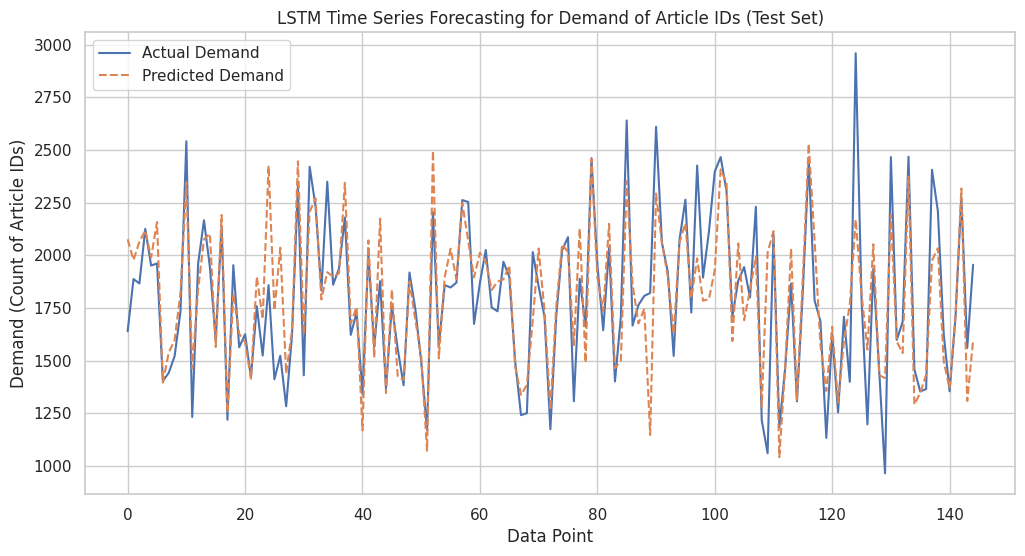

In [120]:
# Reverse the scaling for better interpretation of results
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Demand')
plt.plot(predictions, label='Predicted Demand', linestyle='dashed')
plt.title('LSTM Time Series Forecasting for Demand of Article IDs (Test Set)')
plt.xlabel('Data Point')
plt.ylabel('Demand (Count of Article IDs)')
plt.legend()
plt.show()

# Model for Clothing Reviews

In [130]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [131]:
# Assuming 'product_id' is the common column
top_products_reviews = top_products_reviews.merge(top_products, how='left', left_on='article_id', right_on='article_id')

In [132]:
top_products_reviews.to_csv('top_products_reviews.csv', index=False)

In [133]:
unique_best_match_article_ids = top_products_reviews['article_id'].unique()
len(unique_best_match_article_ids)

3014

In [ ]:
top_products_reviews.head(50)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,1538,947,52,NaN,Love this sweater. fun for fall. soft fabric a...,4,1,0,General,Tops,...,Divided+ inactive from s.1,A,Ladieswear,1.0,Ladieswear,2.0,H&M+,1001.0,Unknown,Off-the-shoulder top in stretch viscose jersey...
1,2857,829,52,"Nice boxy shirt, pretty buttons","Runs really large. i am 5'4"", 120lbs, 32c, and...",4,1,3,General Petite,Tops,...,Projects Jersey & Knitwear,D,Divided,2.0,Divided,50.0,Divided Projects,1005.0,Jersey Fancy,"Fitted body in soft, patterned ribbed jersey w..."
2,16999,944,50,Stylish lucsiously soft sweater!,I see no one has reviewed this yet and since i...,4,1,1,General,Tops,...,Promotion/ Other /Offer,D,Divided,2.0,Divided,50.0,Divided Projects,1023.0,Special Offers,Short top in stretch jersey with a motif on th...
3,20711,945,64,Love but itchy for me,Adorable & unique swtr & wld go w/ many things...,5,1,0,General,Tops,...,Promotion/ Other /Offer,D,Divided,2.0,Divided,50.0,Divided Projects,1023.0,Special Offers,Cropped top in jersey with a small stand-up co...
4,16740,867,29,NaN,I loved this top so much i bought both colors!...,5,1,1,General Petite,Tops,...,Divided+ inactive from s.1,A,Ladieswear,1.0,Ladieswear,2.0,H&M+,1001.0,Unknown,Cotton jersey top with short sleeves with sewn...
5,1318,836,59,Too billowy,Bought this top at my local store and tried it...,3,1,16,General,Tops,...,Promotion/ Other /Offer,D,Divided,2.0,Divided,50.0,Divided Projects,1023.0,Special Offers,"Long-sleeved top in airy, ribbed, printed jersey."
6,17597,824,52,Busty? curvy? no problem!,I adore this blouse. the colors are vibrant (s...,5,1,0,General Petite,Tops,...,Promotion/ Other /Offer,D,Divided,2.0,Divided,50.0,Divided Projects,1023.0,Special Offers,"Short cold-shoulder top in airy, patterned, cr..."
7,8940,862,52,"Comfortable, flattering, seasonless top",I am glad to add this very versitile top to my...,5,1,8,General Petite,Tops,...,Divided+ inactive from s.1,A,Ladieswear,1.0,Ladieswear,2.0,H&M+,1001.0,Unknown,Off-the-shoulder top in stretch viscose jersey...
8,10129,872,53,Great casual top,"Love this top for casual days. fits perfectly,...",5,1,0,General Petite,Tops,...,Divided+ inactive from s.1,A,Ladieswear,1.0,Ladieswear,2.0,H&M+,1001.0,Unknown,Cotton jersey top with short sleeves with sewn...
9,13433,927,37,It's a keep,This is a gorgeous piece-the pattern and color...,5,1,0,General Petite,Tops,...,Divided+ inactive from s.1,A,Ladieswear,1.0,Ladieswear,2.0,H&M+,1001.0,Unknown,Off-the-shoulder blouse in crinkled jersey con...


In [ ]:
top_products_reviews.dtypes

Unnamed: 0                        int64
Clothing ID                       int64
Age                               int64
Title                            object
Review Text                      object
Rating                            int64
Recommended IND                   int64
Positive Feedback Count           int64
Division Name                    object
Department Name                  object
Class Name                       object
article_id                      float64
product_code                    float64
prod_name                        object
product_type_no                 float64
product_type_name                object
product_group_name               object
graphical_appearance_no         float64
graphical_appearance_name        object
colour_group_code               float64
colour_group_name                object
perceived_colour_value_id       float64
perceived_colour_value_name      object
perceived_colour_master_id      float64
perceived_colour_master_name     object


In [134]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [135]:
# Merge table by article_id
top_products_reviews = top_products_reviews.merge(top_products, how='left', left_on='article_id', right_on='article_id')

In [136]:
# Assuming df_product_reviews is your DataFrame
top_products_reviews_encoded = top_products_reviews.copy()

label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in ['Division Name', 'Department Name', 'Class Name']:
    top_products_reviews_encoded[column] = label_encoder.fit_transform(top_products_reviews[column])

top_products_reviews = top_products_reviews_encoded.copy()

In [137]:
top_products_reviews = top_products_reviews.dropna()

In [138]:
top_products_reviews.dtypes

Unnamed: 0                          int64
Clothing ID                         int64
Age                                 int64
Title                              object
Review Text                        object
Rating                              int64
Recommended IND                     int64
Positive Feedback Count             int64
Division Name                       int64
Department Name                     int64
Class Name                          int64
article_id                          int64
product_code_x                    float64
prod_name_x                        object
product_type_no_x                 float64
product_type_name_x                object
product_group_name_x               object
graphical_appearance_no_x         float64
graphical_appearance_name_x        object
colour_group_code_x               float64
colour_group_name_x                object
perceived_colour_value_id_x       float64
perceived_colour_value_name_x      object
perceived_colour_master_id_x      

In [139]:
#columns_to_include =  ['Division Name', 'Department Name', 'Class Name', 'article_id']
#columns_to_include =  ['Division Name', 'Class Name', 'article_id']
columns_to_include =  ['Division Name', 'Class Name', 'Clothing ID', 'article_id']

# Assuming X contains your features (excluding 'Rating') and y contains the target variable 'Rating'
X = top_products_reviews[columns_to_include]
y = top_products_reviews['Rating']

Text(0.5, 1.0, 'Correlation Matrix')

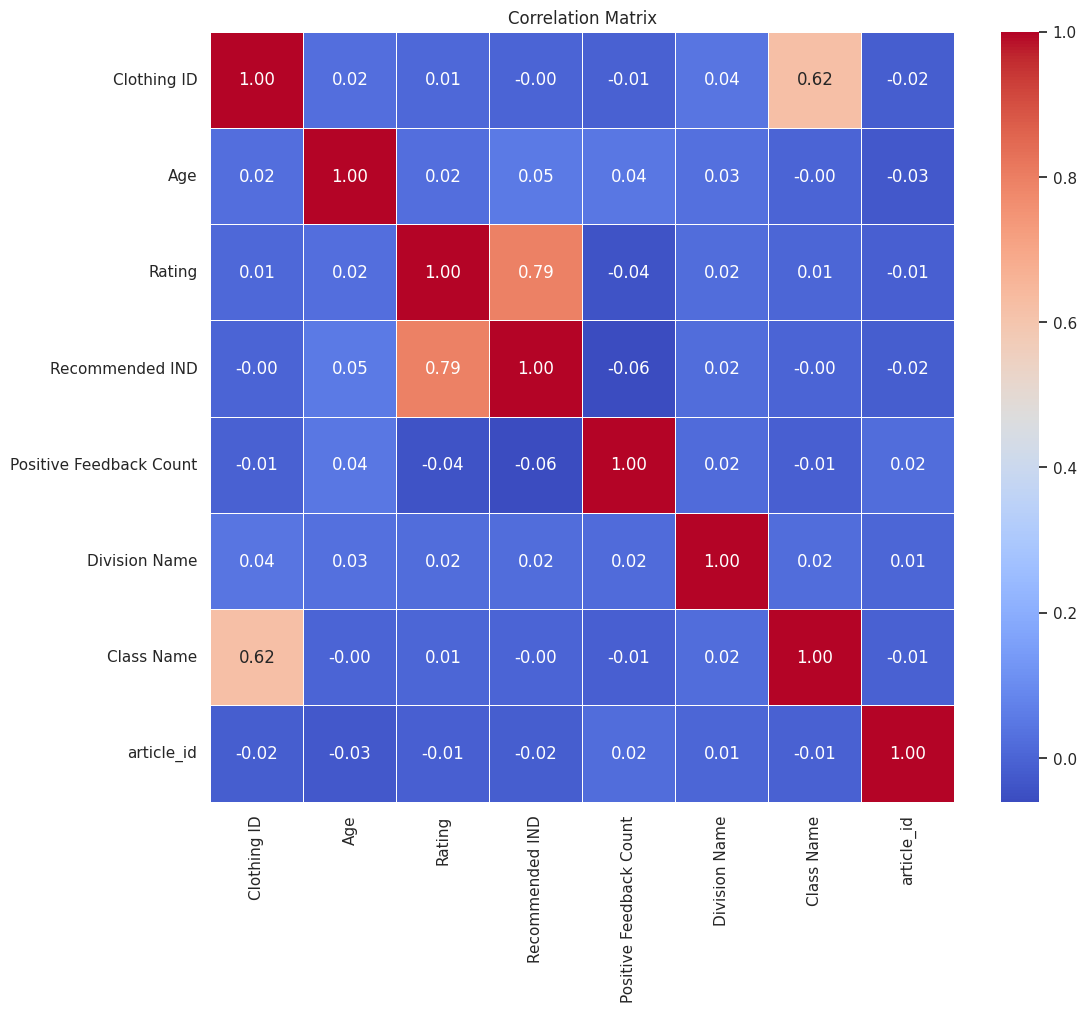

In [140]:
# Selecting columns for correlation analysis
columns_to_include = ['Clothing ID', 'Age', 'Rating', 'Recommended IND', 'Positive Feedback Count',
                       'Division Name', 'Class Name', 'article_id']

# Creating a subset of the DataFrame with selected columns
df_selected = top_products_reviews[columns_to_include]

# Creating a correlation matrix
correlation_matrix = df_selected.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
#plt.show()

In [141]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
X_train = X_train_resampled
y_train = y_train_resampled

In [ ]:
class_counts = y_train.value_counts()
print(class_counts)

5    1161
3    1161
2    1161
1    1161
4    1161
Name: Rating, dtype: int64


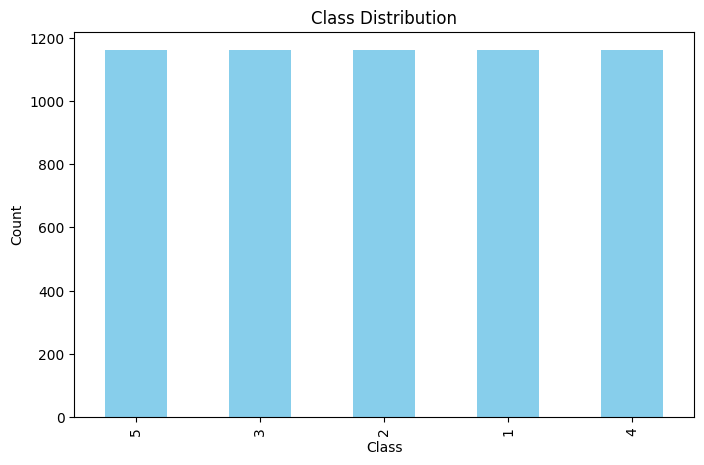

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [143]:
#@title Train Model
# Choose and train the model (Linear Regression in this example)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Create a scaler
scaler = StandardScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

#model = LogisticRegression(random_state=42)
#model.fit(X_train, y_train)

y_train_encoded = label_encoder.fit_transform(y_train)

# Fit and transform the target variable in testing data
y_test_encoded = label_encoder.transform(y_test)

# Now, you can train your XGBoost model using y_train_encoded
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.3,
    max_depth=11,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [7, 9,11,13]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train_encoded)

# Print the best parameters
print(grid_search.best_params_)


In [144]:
# Make predictions on the testing data
y_pred = model.predict(X_test)

In [145]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
mse = mean_squared_error(y_test_encoded, y_pred)
rmse = np.sqrt(mse)
accuracy = accuracy_score(y_test_encoded, y_pred)

# Print Precision, Recall, and F1-score
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error: {mse}')

Accuracy: 0.36323851203501095
Precision: 0.3439485525998677
Recall: 0.36323851203501095
F1-score: 0.35274022429702184
Root Mean Squared Error (RMSE): 1.5654922115209018
Mean Squared Error: 2.450765864332604


<ipython-input-43-38d9c6620c50>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_encoded, label='Actual Ratings', shade=True)
<ipython-input-43-38d9c6620c50>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label='Predicted Ratings', shade=True)


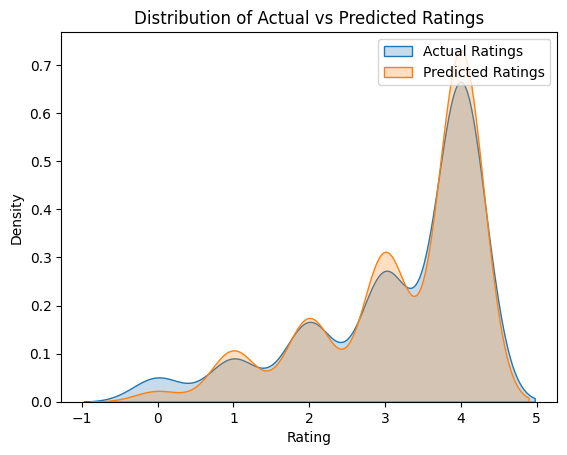

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a kernel density plot
sns.kdeplot(y_test_encoded, label='Actual Ratings', shade=True)
sns.kdeplot(y_pred, label='Predicted Ratings', shade=True)
plt.title('Distribution of Actual vs Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  0   1   2   6  13]
 [  1   2   5   8  23]
 [  0   2  12  15  43]
 [  1  15  16  29  56]
 [  7  23  35  67 161]]


Accuracy: 0.3756906077348066


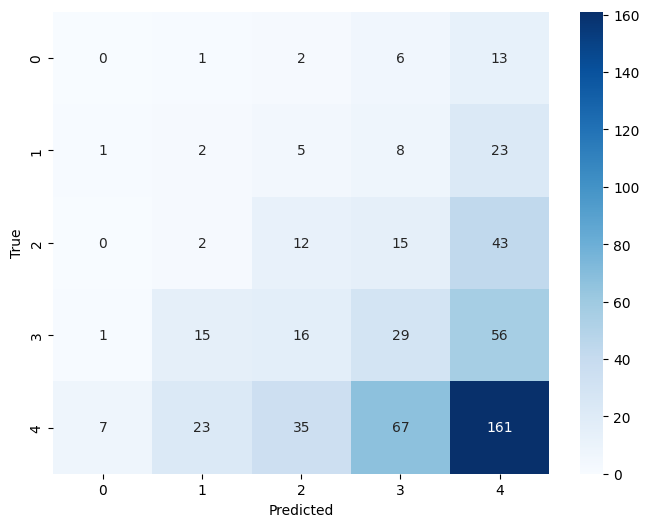

In [ ]:
#@title Plot confusion matrix


# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy}')

# Plot confusion matrix
conf_mat = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#@title Display classification report
from sklearn.metrics import classification_report

classification_rep = classification_report(y_test_encoded,y_pred)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.05      0.05      0.05        39
           2       0.17      0.17      0.17        72
           3       0.23      0.25      0.24       117
           4       0.54      0.55      0.55       293

    accuracy                           0.38       543
   macro avg       0.20      0.20      0.20       543
weighted avg       0.37      0.38      0.37       543



# Prophet

In [ ]:
from prophet import Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsocsqsyc/b0msks49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsocsqsyc/z0syvfu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=718', 'data', 'file=/tmp/tmpsocsqsyc/b0msks49.json', 'init=/tmp/tmpsocsqsyc/z0syvfu5.json', 'output', 'file=/tmp/tmpsocsqsyc/prophet_modeljpksihme/prophet_model-20231127030354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


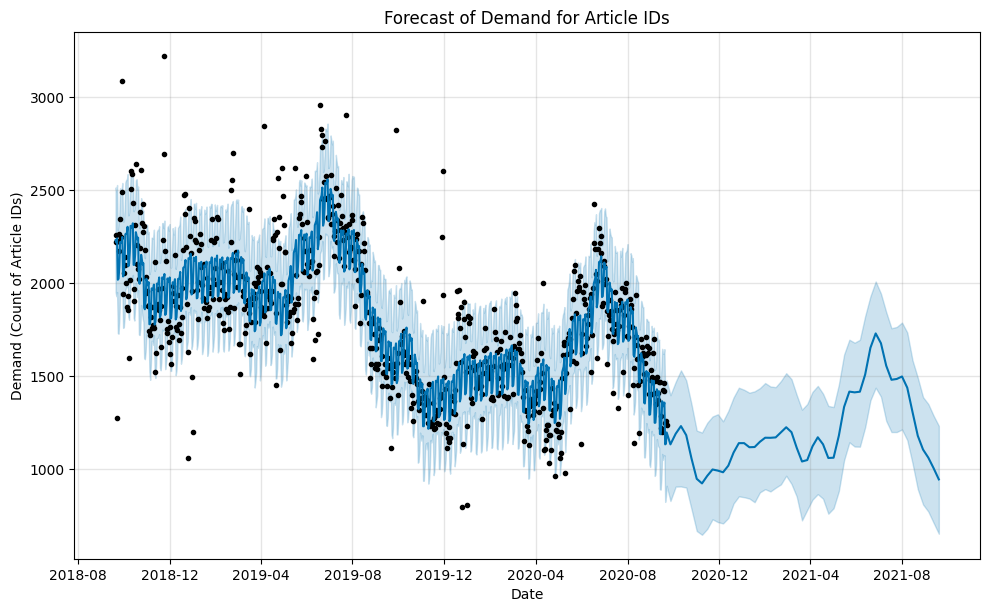

In [ ]:
time_series_data = filtered_merged_df.groupby('t_dat')['article_id'].nunique().reset_index()
time_series_data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Initialize Prophet model
model = Prophet(yearly_seasonality=True)

# Fit the model
model.fit(time_series_data)

# Create a DataFrame with future dates for forecasting
future = model.make_future_dataframe(periods=52, freq='W')  # Adjust the number of future periods as needed

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Demand for Article IDs')
plt.xlabel('Date')
plt.ylabel('Demand (Count of Article IDs)')
plt.show()

# Generative AI

## DALL-E

In [41]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [42]:
import openai
import requests
import io
from PIL import Image
from io import BytesIO

In [ ]:
# DELETE!
# Open the JPG image
jpg_image_path = "/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg"
jpg_image = Image.open(jpg_image_path)

# Create an in-memory binary stream to save the PNG image
png_image_stream = io.BytesIO()

# Save the image as PNG to the in-memory stream
jpg_image.save(png_image_stream, format="PNG")

# Optionally, save the PNG image to a file
png_image_path = "/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/images/010/0108775044.png"
jpg_image.save(png_image_path, format="PNG")

# Close the original JPG image
jpg_image.close()

In [44]:
#@title Image Data
from PIL import Image
# Open the JPG image
jpg_image_path = "/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg"
jpg_image = Image.open(jpg_image_path)

# Convert the image to RGBA
rgba_image = jpg_image.convert("RGBA")

# Create an in-memory binary stream to save the PNG image
png_image_stream = io.BytesIO()

# Save the image as PNG to the in-memory stream
rgba_image.save(png_image_stream, format="PNG")

# Optionally, save the PNG image to a file
png_image_path = "/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/images/010/0108775044.png"
rgba_image.save(png_image_path, format="PNG")

# Close the original JPG image and the RGBA image
jpg_image.close()
rgba_image.close()

In [47]:
from openai import OpenAI
client = OpenAI(api_key=openai.api_key)

In [52]:
response = client.images.generate(
  model="dall-e-3",
  prompt="red, blue and green bras from H&M on white background",
  size="1024x1024",
  quality="standard",
  n=1,
)

In [ ]:
response = client.images.create_variation(
  image=open(png_image_path, "rb"),
  n=4,
  size="256x256"
)

In [53]:
image_url_list = []
image_data_list = []

for image in response.data:
    image_url_list.append(image.model_dump()["url"])
    image_data_list.append(image.model_dump()["b64_json"])

In [54]:
# Extract image URLs from the response
from IPython.display import Image, display, HTML

# Display or save the generated images
image_html = ""
for i, image_url in enumerate(image_url_list):
    image_data = requests.get(image_url).content
    # Display the image
    img = Image(data=image_data, width=256, height=256)
    #image_html += f"<div style='display:inline-block; margin: 10px;'>{img._repr_html_()}</div>"
    image_html += f"<img src='{image_url}' width='256' height='256' style='margin: 10px;'>"

display(HTML(image_html))

In [55]:
!pip install replicate

In [66]:
import replicate

In [67]:
import os
os.environ['REPLICATE_API_TOKEN'] = 'r8_TAxBIDDrCRUDdizehPZilwofo6eFbQw4Sj5f4'

In [68]:
API_TOKEN = "r8_TAxBIDDrCRUDdizehPZilwofo6eFbQw4Sj5f4"  # Paste your API token here

import os
os.environ["REPLICATE_API_TOKEN"] = API_TOKEN

In [69]:
replicate = replicate.Client(api_token='r8_TAxBIDDrCRUDdizehPZilwofo6eFbQw4Sj5f4')
model = replicate.models.get("stability-ai/stable-diffusion")

In [70]:
output = replicate.run(
  "stability-ai/stable-diffusion:27b93a2413e7f36cd83da926f3656280b2931564ff050bf9575f1fdf9bcd7478",
  input={
      "prompt": "red, blue and green bras from H&M on white background",
      "num_outputs": 3
  }
)

output_image = output[0]  # Get the URL of the generated image

In [71]:
from IPython.display import Image
Image(url=output[0])